# Sprint9 深層学習スクラッチ ニューラルネットワーク

## 1.このSprintについて

### Sprintの目的
- スクラッチを通してニューラルネットワークの基礎を理解する
- 画像データの扱い方を知る

### どのように学ぶか
スクラッチで単純なニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.MNISTデータセット
ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用します。各種ライブラリやサイトからダウンロードできますが、ここでは深層学習フレームワークのKerasを用います。以下のコードを実行すればデータセットをダウンロードし、展開まで行えます。

#### 《データセットをダウンロードするコード》

```
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
```

#### 《MNISTとは？》

画像分類のための定番データセットで、手書き数字認識を行います。このデータセットには訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベルが含まれています。

#### 《画像データとは？》

デジタル画像は点の集合で、これをピクセルと呼びます。一般的に白黒画像であればピクセルには0〜255の値が含まれます。一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。機械学習をする上では、この0〜255の値一つひとつが

### データセットの確認
どういったデータなのかを見てみます。

#### 《サンプルコード》

```
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])
```

各データは28×28ピクセルの白黒画像です。

#### 平滑化
(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。全てのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現します。

#### 《サンプルコード》

```
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
```

#### 《補足》

ここまで機械学習を学んでくる中で、特徴量の数を「次元」と呼んできました。その視点ではMNISTは784次元のデータです。一方で、NumPyのshapeが(784,)の状態を1次元配列とも呼びます。画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列です。この視点では2次元のデータです。さらに、もしもカラー画像であれば(28, 28, 3)ということになり、3次元配列です。先ほどの視点では3次元のデータになります。しかし、白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータです。画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意してください。

### 画像データの可視化
画像データを可視化します。plt.imshowに渡します。

#### 《サンプルコード》

```
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
```

[numpy.reshape — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)

[matplotlib.pyplot.imshow — Matplotlib 3.1.1 documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html)

#### 《発展的話題》

画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどと全く同じ風に表示されます。

```
import numpy as np

index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認
```

これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。

```
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
```

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておきましょう。

### 前処理
画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。

#### 《サンプルコード》

```
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0
```

また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

#### 《サンプルコード》

```
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64
```

[sklearn.preprocessing.OneHotEncoder — scikit-learn 0.21.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

さらに、訓練用データ6万枚の内2割を検証用データとして分割してください。訓練用データが48000枚、検証用データが12000枚となります。

#### 《サンプルコード》

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn import metrics

Using TensorFlow backend.


```
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)
```

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

1.0
0.0
(48000, 784)
(12000, 784)


## 3.ニューラルネットワークスクラッチ
ニューラルネットワークのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

今回は多クラス分類を行う3層のニューラルネットワークを作成します。層の数などは固定した上でニューラルネットワークの基本を学びます。次のSprintで層を自由に変えられる設計にしていきます。

以下に雛形を用意してあります。このScratchSimpleNeuralNetrowkClassifierクラスにコードを書き加えていってください。

#### 《雛形》
```
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, verbose = True):
        self.verbose = verbose
        pass

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """

        pass
        return
```

### ミニバッチ処理
これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。

今回はバッチサイズを20とします。今回使う訓練用データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練用データを一度全て見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。

これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

#### 《コード》

In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

このクラスをインスタンス化し、for文を使うことでミニバッチが取り出せます。

```
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)

print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass
```

__getitem__や__next__は__init__と同じ特殊メソッドの一種です。

### 学習
ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。

重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。

以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

#### 《サンプルコード》
```
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)
```

[numpy.random.randn — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html)

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題2】フォワードプロパゲーションの実装
三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。

各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

#### 「1層目」
$$A_1 = X \cdot W_1 + B_1$$

$X$  : 特徴量ベクトル (batch_size, n_features)

$W_1$ : 1層目の重み (n_features, n_nodes1)

$B_1$ : 1層目のバイアス (n_nodes1,)

$A_1$ : 出力 (batch_size, n_nodes1)

#### 「1層目の活性化関数」
$$Z_1 = f(A_1)$$

$f()$  : 活性化関数

$Z_1$　: 出力 (batch_size, n_nodes1)

#### 「2層目」
$$A_2 = Z_1 \cdot W_2 + B_2$$

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)

$B_2$ : 2層目のバイアス (n_nodes2,)

$A_2$ : 出力 (batch_size, n_nodes2)

#### 「2層目の活性化関数」
$$Z_2 = f(A_2)$$

$f()$  : 活性化関数

$Z_2$ : 出力 (batch_size, n_nodes2)

#### 「3層目（出力層）」
$$A_3 = Z_2 \cdot W_3 + B_3$$

$W_3$  : 3層目の重み (n_nodes2, n_output)

$B_3$ : 3層目のバイアス (n_output,)

$A_3$ : 出力 (batch_size, n_output)

#### 「3層目の活性化関数」
$$Z_3 = softmax(A_3)$$

$softmax()$  : ソフトマックス関数

$Z_3$ 出力 (batch_size, n_output)

$Z_3$ は各ラベル（0〜9）に対する確率の配列である。

### 活性化関数（フォワードプロバゲーション）
活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。

#### 「シグモイド関数」
$$f(Z) = sigmoid(A) = \frac{1}{1 + exp(-A)}$$

指数関数 $exp(−A)$ の計算はnp.expを使用してください。

[numpy.exp — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.exp.html)

「ハイパボリックタンジェント関数」

次の数式で表されますが、np.tanhひとつで実現できます。

$$f(Z) = tanh(A) = \frac{exp(A) - exp(-A)}{exp(A) + exp(-A)}$$

[numpy.tanh — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.tanh.html)

＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。

### ソフトマックス関数
ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。

次の数式です。
$$Z_{3_k} = \frac{exp(A_{3_k}}{\sum_{i=1}^{n_c}exp(A_{3_i})}$$

$Z_{3_k}  :　k 番目のクラスの確率ベクトル (batch_size,)

$A_{3_k} :　k 番目のクラスにあたる前の層からのベクトル (batch_size,)

$n_c$ : クラスの数、n_output。今回のMNISTでは10。

分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に$k$ 番目のクラスを持ってくることで、 $k$ 番目のクラスである確率が求まります。

これを10クラス分計算し、合わせたものが $Z_3$ です。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題3】交差エントロピー誤差の実装
目的関数（損失関数）を作成します。

多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。
$$L = -\frac{1}{n_b}\sum_j^{n_b}\sum_k^{n_c}y_jk\log(z_{3_{jk}})$$


$y_{jk}$  : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）

$z_{3_{jk}}$ : $j$ 番目のサンプルの$k$ 番目のクラスの確率（スカラー）

$n_b$ : バッチサイズ、batch_size

$n_c$ : クラスの数、n_output（今回のMNISTでは10）

サンプル1つあたりの誤差が求まります。

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題4】バックプロパゲーションの実装
三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。

数式を以下に示します。

まず、i層目の重みとバイアスの更新式です。 $W_i$ と$B_i$ に対し、更新後の $W'_i$ と $B'_i$ は次の数式で求められます。
$$W'_i = W_i - \alpha\frac{\partial L}{\partial W_i}$$
$$B'_i = B_i - \alpha\frac{\partial L}{\partial B_i}$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的には全て同じとする）

$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配

この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。

勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。

#### 「3層目」

$$\frac{\partial L}{\partial A_3} = \frac{1}{n_b}\sum_j^{n_b}(Z_{3_j} - Y_j)$$
$$\frac{\partial L}{\partial B_3} = \frac{\partial L}{\partial A_3}$$
$$\frac{\partial L}{\partial W_3} = \left(\frac{1}{n_b}\sum_j^{n_b}Z_{2_j}^T\right) \cdot \frac{\partial L}{\partial A_3}$$
$$\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_3} \cdot W_3^T$$

$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (1, n_output)

$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (1, n_output)

$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)

$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (1, n_nodes2)

$Z_{3_j} : $j$ 番目のサンプルの3層目の出力 (1, n_output)

$Y_j$ : $j$ 番目のサンプルの正解ラベル (1, n_output)

$Z_{2_j}$ :$j$ 番目のサンプルの2層目の出力 (n_nodes2, 1)

$W_3$ : 3層目の重み (n_nodes2, n_output)

#### 「2層目」

$$\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \cdot ( 1 - tanh^2(\frac{1}{n_b}\sum_j^{n_b}A_{2_j}))$$
$$\frac{\partial L}{\partial B_2} = \frac{\partial L}{\partial A_2}$$
$$\frac{\partial L}{\partial W_2} = \left(\frac{1}{n_b}\sum_j^{n_b}Z_{1_j}^T\right) \cdot \frac{\partial L}{\partial A_2}$$
$$\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_2} \cdot W_2^T$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (1, n_nodes2)

$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (1, n_nodes2)

$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)

$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (1, n_nodes2)

$Z_{2_j}$ : $j$ 番目のサンプルの2層目の出力 (1, n_nodes2)

$A_{2_j}$ : $j$ 番目のサンプルの2層目の活性化関数の出力 (1, n_nodes2)

$Z_{1_j}$ : $j$ 番目のサンプルの1層目の出力 (n_nodes1, 1)

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)

#### 「1層目」
$$\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \cdot ( 1 - tanh^2(\frac{1}{n_b}\sum_j^{n_b}A_{1_j}))$$
$$\frac{\partial L}{\partial B_1} = \frac{\partial L}{\partial A_1}$$
$$\frac{\partial L}{\partial W_1} = \left(\frac{1}{n_b}\sum_j^{n_b}X_j^T\right) \cdot \frac{\partial L}{\partial A_1}$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (1, n_nodes1)

$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (1, n_nodes1)

$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)

$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (1, n_nodes1)

$Z_{1_j}$ : $j$ 番目のサンプルの1層目の出力 (1, n_nodes2)

$A_{1_j}$ : $j$ 番目のサンプルの1層目の活性化関数の出力 (1, n_nodes1)

$X_j$ : $j$ 番目のサンプル (n_features, 1)

$W_1$ : 1層目の重み (n_features, n_nodes1)

#### 《補足》

活性化関数にシグモイド関数を使用した場合は、次のようになります。
$$\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \cdot \left\{1 - sigmoid\left(\frac{1}{n_b}\sum_j^{n_b}A_{2_j}\right)\right\}sigmoid\left(\frac{1}{n_b}\sum_j^{n_b}A_{2_j}\right)$$

$$\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \cdot \left\{1 - sigmoid\left(\frac{1}{n_b}\sum_j^{n_b}A_{1_j}\right)\right\}sigmoid\left(\frac{1}{n_b}\sum_j^{n_b}A_{1_j}\right)$$

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題5】推定
推定を行うメソッドを作成してください。

フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

[numpy.argmax — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html)

In [4]:
#問題1～5は下記クラスにまとめて実装

class ScratchSimpleNeuralNetrowkClassifier1():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch=2, lr=0.01, verbose=True):
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.W1, self.W2, self.W3 = None, None, None
        self.B1, self.B2, self.B3 = None, None, None
        self.A1, self.A2, self.A3 = None, None, None
        self.Z1, self.Z2, self.Z3 = None, None, None
        self.mini_y_train = None
        self.train_loss_list = []
        self.val_loss_list = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
        
        n_features = X.shape[1]
        n_nodes1 = 400
        n_nodes2 = 200
        sigma = 0.01 # ガウス分布の標準偏差
        batch_size = 20
        n_output = 10
        
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.W3 = sigma * np.random.randn(n_nodes2, n_output)
        self.B1 = np.zeros(n_nodes1)
        self.B2 = np.zeros(n_nodes2)
        self.B3 = np.zeros(n_output)
        
        get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
        if self.verbose:
            print("train data learning process\n")
        for _ in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:
                self.mini_y_train = mini_y_train
                self.forward_propagation(mini_X_train)
                self.back_propagation(mini_X_train)
                
                if self.verbose:
                    #verboseをTrueにした際は学習過程などを出力する
                    print("W1\n{}\n".format(self.W1))
                    print("W2\n{}\n".format(self.W2))
                    print("W3\n{}\n".format(self.W3))
                    print("B1\n{}\n".format(self.B1))
                    print("B2\n{}\n".format(self.B2))
                    print("B3\n{}\n".format(self.B3))
            
            self.forward_propagation(X)
            train_loss = self.get_loss(self.Z3, y_train_one_hot)
            self.train_loss_list.append(train_loss)
            self.forward_propagation(X_val)
            val_loss = self.get_loss(self.Z3, y_val_one_hot)
            self.val_loss_list.append(val_loss)
                
    def forward_propagation(self, X):
        """
        X:特徴量ベクトル(20, 784)
        W1:1層目の重み(784, 400)
        B1:1層目のバイアス(400, )
        A1:出力(20, 400)
        Z1:出力(20, 400)
        """
        # 1層目
        self.A1 = X@self.W1 + self.B1 #shape(20, 400)
        self.Z1 = self.hyperbolic_tangent(self.A1) #shape(20, 400)
        
        # 2層目
        self.A2 = self.Z1@self.W2 + self.B2 #shape(20, 200)
        self.Z2 = self.hyperbolic_tangent(self.A2) #shape(20, 200)
    
        # 3層目
        self.A3 = self.Z2@self.W3 + self.B3 #shaoe(20, 10)
        self.Z3 = self.soft_max(self.A3) #shape(20, 10)
    
    def sigmoid(self, A):
        sig = 1 / (1 + np.exp(-1*A))
        return sig
    
    def hyperbolic_tangent(self, A):
        tanh = np.tanh(A)
        return tanh
    
    def soft_max(self, A):
        Z = np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)
        return Z
    
    def get_loss(self, Z, y):
        loss = -1 * np.mean(np.sum(y * np.log(Z), axis=1))
        return loss
    
    def back_propagation(self, X):
        # 3層目
        b_A3 = np.mean(self.Z3 - self.mini_y_train, axis=0).reshape(1, -1) #shape(1, 10)
        b_W3 = np.mean(self.Z2, axis=0).T.reshape(-1, 1) @ b_A3 #shape(200, 10)
        b_B3 = b_A3 #shape(1, 10)
        b_Z2 = b_A3 @ self.W3.T #shape(1, 200)
        
        self.W3 = self.W3 - self.lr*b_W3
        self.B3 = self.B3 - self.lr*b_B3
        
        # 2層目
        b_A2 = b_Z2 * (1 - np.tanh(np.mean(self.A2, axis=0))**2) #shape(1, 200)
        b_B2 = b_A2 #shape(1, 200)
        b_W2 = np.mean(self.Z1, axis=0).T.reshape(-1, 1) @ b_A2 #shape(400, 200)
        b_Z1 = b_A2 @ self.W2.T #shape(1, 400)
        
        self.W2 = self.W2 - self.lr*b_W2
        self.B2 = self.B2 - self.lr*b_B2
        
        # 1層目
        b_A1 = b_Z1 * (1 - np.tanh(np.mean(self.A1, axis=0))**2) #shape(1, 400)
        b_B1 = b_A1 #shape(1, 400)
        b_W1 = np.mean(X, axis=0).T.reshape(-1, 1) @ b_A1 #shape(784, 400)
        
        self.W1 = self.W1 - self.lr*b_W1
        self.B1 = self.B1 - self.lr*b_B1
    
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.forward_propagation(X)
        y_pred = self.Z3
        y_pred = np.argmax(y_pred, axis=1)
        return y_pred

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題6】学習と推定
MNISTのデータを学習・推定し、Accuracyを計算してください。

In [11]:
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
nn1 = ScratchSimpleNeuralNetrowkClassifier1(lr=0.1, epoch=10, verbose=False)
nn1.fit(X_train, y_train, X_val, y_val)
y_pred = nn1.predict(X_val)
print(metrics.accuracy_score(y_val, y_pred1))

0.87175


＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題7】学習曲線のプロット
学習曲線をプロットしてください。

ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。trainデータとvalデータに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

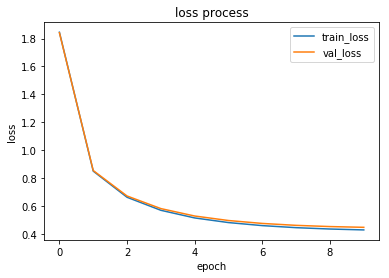

In [12]:
plt.title("loss process")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(nn1.train_loss_list, label='train_loss')
plt.plot(nn1.val_loss_list, label='val_loss')
plt.legend()
plt.show()

＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿＿
### 【問題8】（アドバンス課題）誤分類の確認
誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。

#### 《コード》

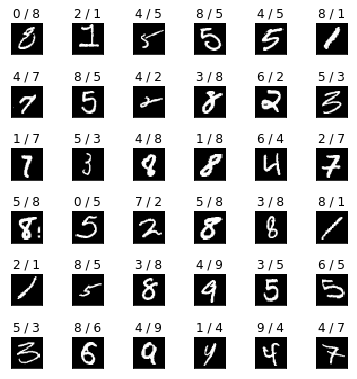

In [13]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""

num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')